# [Work in progress] Asset allocation: from Markowitz to the machine age

In this notebook, we will present and compare various asset allocation methods, along with their default and strenghts.
A particular focus will deal with what we call risk-based asset allocation, where covariance matrices play an important role.

If we denote $\Sigma$ to be the covariance matrix of stock returns, we denote the risk of the portfolio holding these stocks by:

\begin{equation*}
	\sigma (x) 
	= \sqrt{x^T\Sigma x} 
\end{equation*}

## Presentation of the different asset allocations considered in this notebook:

- **EQL**: _Equal weights portfolio_: A strategy that chooses $\omega_i = 1/N$ for all $i$. 

- **MVP**: _Mean variance portfolio_: A strategy aiming at maximizing returns while controlling for portfolio risk.
	\begin{equation}\label{eq:mvp}
			\max_{x\in \Pi} \quad  x^T R\quad s.t. \quad \frac{1}{2}x^{T}\Sigma x \leq c
	\end{equation}

-  **MV** portfolio _Minimum variance portfolio_: A strategy that invests in stocks that give a minimal risk.

	\begin{equation}\label{eq:mv}
			\min_{x\in \Pi} \quad  \frac{1}{2}x^{T}\Sigma x
	\end{equation}

- **ERC** for _equal risk contribution portfolio_: A strategy that invests in stocks in a way that all stocks have the same risk contribution

\begin{equation}\label{eq:erc}
    \min_{x\in \Pi} \quad \sum_{i=1}^{N} \sum_{j=1}^{N}{\left(x_i{(\Sigma x)}_i - x_j{(\Sigma x)}_j \right)}^2
\end{equation}

- **INV
- **MDP** for _maximum diversification portfolio_: A strategy aiming at equalizing correlations of stocks w.r.to the formed portfolio through maximizing the diversification ratio (DR).
	\begin{equation}\label{eq:mdp}
		\max_{x\in \Pi} \quad DR(x) := \frac{\sum_{i=1}^{N} x_i \sigma_i}{\sigma(x)}
	\end{equation}
    
$\Pi$ represents the constraints set.

- **HERC** for _hierarchical equal risk contribution_: A strategy that leverages the hierarchical structure of correlation matrices to construct the allocations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from research.config import plots
plots.init(width=10)
plots.toggle_spines(True, True)
plots.toggle_grid(True, True)
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

In [3]:
from tqdm import tqdm

In [4]:
from research.visualization import correlation_plot
from research.portfolio.allocation import *
from research.portfolio.statistics import *
from research.portfolio.utils import drift_weights

In [5]:
returns = pd.read_parquet('pickles/returns.parquet')

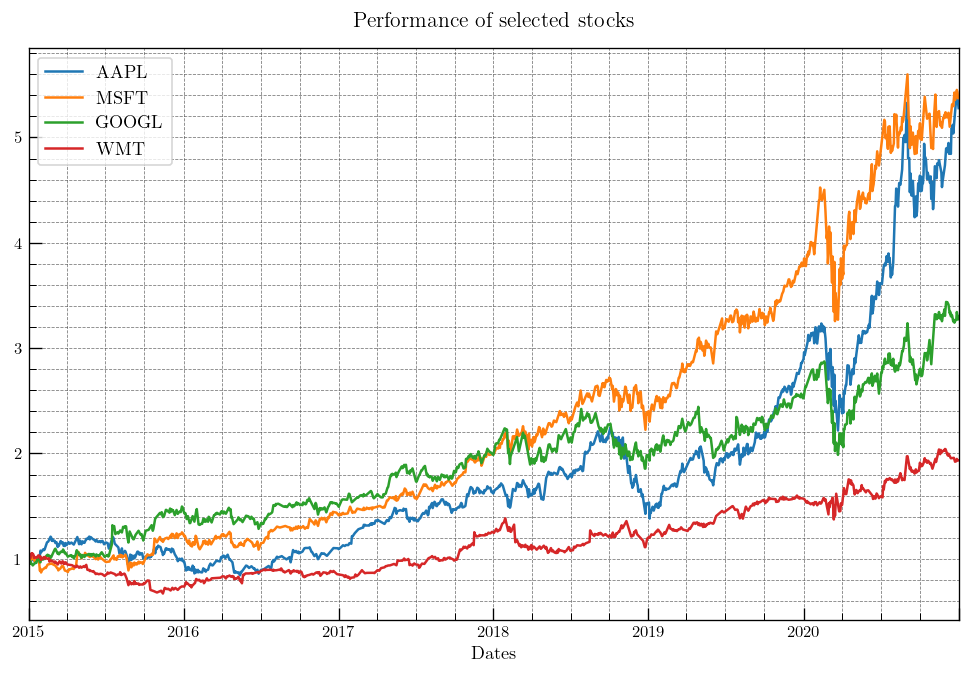

In [6]:
returns.loc['2015':'2020', ['AAPL', 'MSFT', 'GOOGL', 'WMT']].add(1).cumprod().plot(legend=True, title='Performance of selected stocks');

In [7]:
nb_periods, nb_stocks = returns.shape

In [8]:
fstdate = returns.index[0] + pd.offsets.BMonthEnd()
# Strategy Start Date (3 year later to account for covariance matrix calculation)
offset = 3
ssdate = fstdate + pd.offsets.BYearEnd(offset) 
# Last Rebalancing Date
lrdate = returns.index[-1] - pd.offsets.BMonthEnd()
# Initialization
date = ssdate
universe = returns.columns

In [9]:
rebal_dates = returns[ssdate:].resample('BM').last().index
rebal_dates = rebal_dates[rebal_dates <= returns.index[-1]]
shifted_dates = rebal_dates - pd.offsets.BMonthEnd(3*12)

We compute the weights for each portfolio and drift the weights between two rebalancing dates

In [10]:
use_saved = True

In [11]:
if use_saved:
    erc_dwt = pd.read_parquet('pickles/erc_dwt.parquet')
    mvp_dwt = pd.read_parquet('pickles/mvp_dwt.parquet')
    hrc_dwt = pd.read_parquet('pickles/hrc_dwt.parquet')
    eql_dwt = pd.read_parquet('pickles/eql_dwt.parquet')
    inv_dwt = pd.read_parquet('pickles/inv_dwt.parquet')
    
    erc_wt = pd.read_parquet('pickles/erc_wt.parquet')
    mvp_wt = pd.read_parquet('pickles/mvp_wt.parquet')
    hrc_wt = pd.read_parquet('pickles/hrc_wt.parquet')
    eql_wt = pd.read_parquet('pickles/eql_wt.parquet')
    inv_wt = pd.read_parquet('pickles/inv_wt.parquet')
    
else:
    # Weights
    erc_wt = pd.DataFrame(0, columns=returns.columns, index=rebal_dates)  # Equal risk contribution portfolio
    mvp_wt = pd.DataFrame(0, columns=returns.columns, index=rebal_dates)  # minimum variance portfolio
    hrc_wt = pd.DataFrame(0, columns=returns.columns, index=rebal_dates)  # Hierarchical Equal risk contribution portfolio
    eql_wt = pd.DataFrame(0, columns=returns.columns, index=rebal_dates)  # Equal weight portfolio
    inv_wt = pd.DataFrame(0, columns=returns.columns, index=rebal_dates)  # Inverse volatility portfolio
    # mdp_wt = pd.DataFrame(columns=returns.columns, index=rebal_dates)  # Maximum diversification portfolio
    # hdp_wt = pd.DataFrame(columns=returns.columns, index=rebal_dates)  # hierarchical average correlation  portfolio

    for date, rebal_date in tqdm(zip(shifted_dates, rebal_dates), total=len(rebal_dates)):
        rets = returns.loc[date:rebal_date, :].dropna(how='all', axis=1)
        stocks = rets.columns
        cov = rets.cov()
        erc_wt.loc[rebal_date, stocks] = risk_parity(cov)
        mvp_wt.loc[rebal_date, stocks] = minimum_volatility(cov)
        hrc_wt.loc[rebal_date, stocks] = hierarchical_equal_risk_contribution(cov)
        eql_wt.loc[rebal_date, stocks] = 1 / len(stocks)
        inv_wt.loc[rebal_date, stocks] = inverse_vol(cov)
    
    eql_wt.index += pd.offsets.BDay()
    erc_wt.index += pd.offsets.BDay()
    hrc_wt.index += pd.offsets.BDay()
    inv_wt.index += pd.offsets.BDay()
    mvp_wt.index += pd.offsets.BDay()
    
    erc_dwt = drift_weights(returns.loc[ssdate:], erc_wt)
    hrc_dwt = drift_weights(returns.loc[ssdate:], hrc_wt)
    eql_dwt = drift_weights(returns.loc[ssdate:], eql_wt)
    inv_dwt = drift_weights(returns.loc[ssdate:], inv_wt)
    mvp_dwt = drift_weights(returns.loc[ssdate:], mvp_wt)

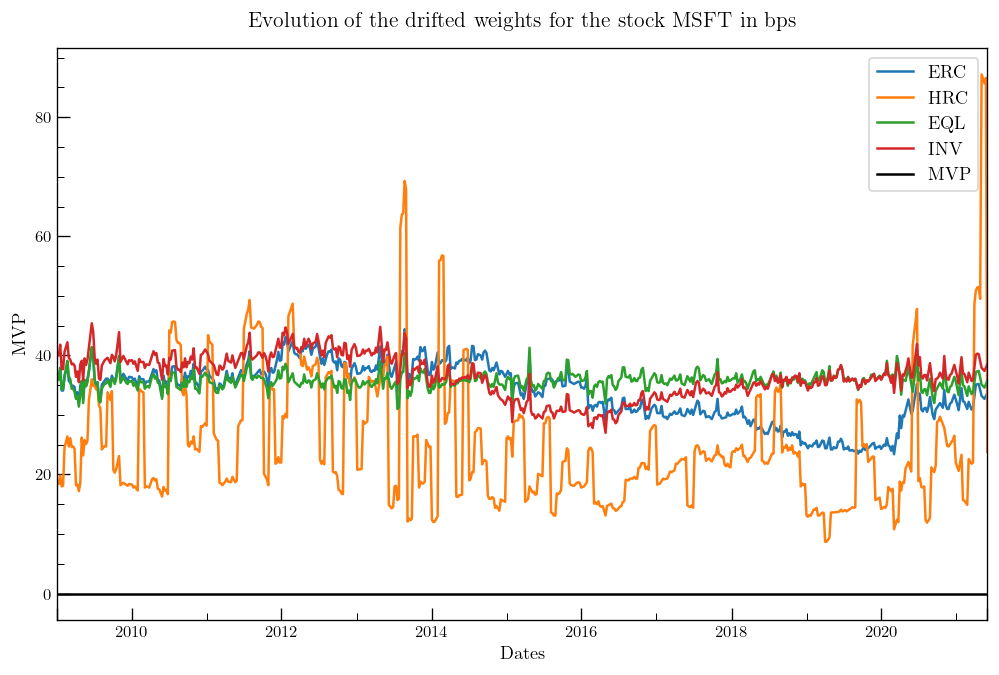

In [12]:
with plt.rc_context({'axes.grid': False}):
    erc_dwt['MSFT'].resample('W').last().mul(10000).round(1).plot(label='ERC')
    hrc_dwt['MSFT'].resample('W').last().mul(10000).round(1).plot(label='HRC')
    eql_dwt['MSFT'].resample('W').last().mul(10000).round(1).plot(label='EQL')
    inv_dwt['MSFT'].resample('W').last().mul(10000).round(1).plot(label='INV')
    plt.ylabel('Other methods')
    mvp_dwt['MSFT'].resample('1BM').last().mul(10000).round(1).plot(label='MVP', ylabel='MVP', color='k')
    plt.title('Evolution of the drifted weights for the stock MSFT in bps')
    plt.legend()

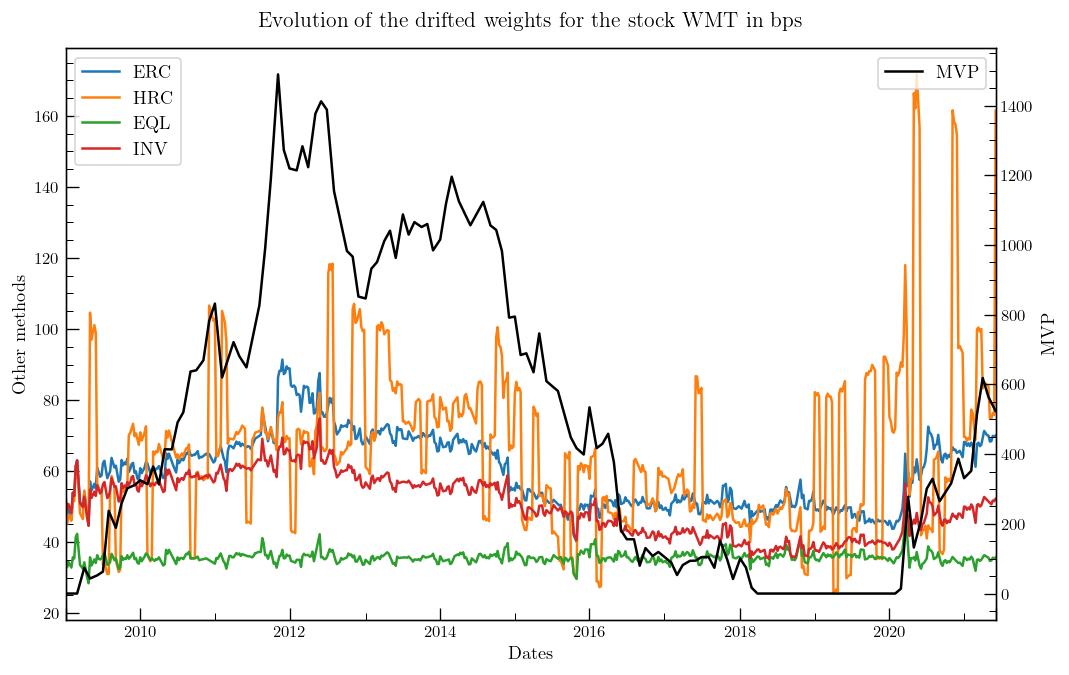

In [13]:
with plt.rc_context({'axes.grid': False}):
    erc_dwt['WMT'].resample('W').last().mul(10000).round(1).plot(label='ERC')
    hrc_dwt['WMT'].resample('W').last().mul(10000).round(1).plot(label='HRC')
    eql_dwt['WMT'].resample('W').last().mul(10000).round(1).plot(label='EQL')
    inv_dwt['WMT'].resample('W').last().mul(10000).round(1).plot(label='INV')
    plt.ylabel('Other methods')
    plt.legend();
    plt.twinx()
    mvp_dwt['WMT'].resample('1BM').last().mul(10000).round(1).plot(label='MVP', ylabel='MVP', color='k')
    plt.title('Evolution of the drifted weights for the stock WMT in bps')
    plt.legend()

In [14]:
# Volatility
erc_vol = pd.DataFrame(0, columns=['Volatility'], index=rebal_dates, dtype='float64')
mvp_vol = pd.DataFrame(0, columns=['Volatility'], index=rebal_dates, dtype='float64')
hrc_vol = pd.DataFrame(0, columns=['Volatility'], index=rebal_dates, dtype='float64')
eql_vol = pd.DataFrame(0, columns=['Volatility'], index=rebal_dates, dtype='float64')
inv_vol = pd.DataFrame(0, columns=['Volatility'], index=rebal_dates, dtype='float64')

# mdp_vol = pd.DataFrame(columns=['Volatility'], index=rebal_dates, dtype='float64')
# hdp_vol = pd.DataFrame(columns=['Volatility'], index=rebal_dates, dtype='float64')

In [15]:
for date, rebal_date in tqdm(zip(shifted_dates, rebal_dates), total=len(rebal_dates)):
    rets = returns.loc[date:rebal_date, :].dropna(how='all', axis=1)
    stocks = rets.columns
    cov = rets.cov()
    wd = rebal_date + pd.offsets.BDay()
    erc_vol.loc[rebal_date] = portfolio_volatility(cov, erc_dwt.loc[wd]) * np.sqrt(252)
    hrc_vol.loc[rebal_date] = portfolio_volatility(cov, hrc_dwt.loc[wd]) * np.sqrt(252)
    eql_vol.loc[rebal_date] = portfolio_volatility(cov, eql_dwt.loc[wd]) * np.sqrt(252)
    inv_vol.loc[rebal_date] = portfolio_volatility(cov, inv_dwt.loc[wd]) * np.sqrt(252)
    mvp_vol.loc[rebal_date] = portfolio_volatility(cov, mvp_dwt.loc[wd]) * np.sqrt(252)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.48it/s]


In [16]:
effective_dates = eql_dwt.index
returns = returns.loc[effective_dates]

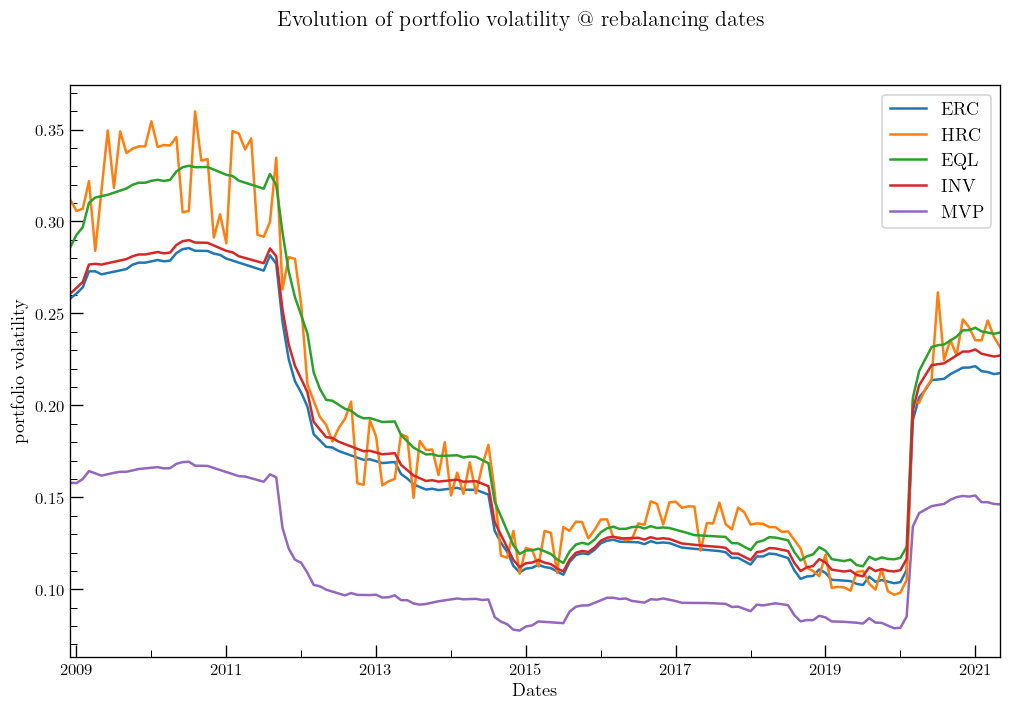

In [17]:
with plt.rc_context({'axes.grid':False}):
    fig, ax = plt.subplots()
    erc_vol.plot(ax=ax, label='ERC', legend=False)
    hrc_vol.plot(ax=ax, label='HRC', legend=False)
    eql_vol.plot(ax=ax, label='EQL', legend=False)
    inv_vol.plot(ax=ax, label='INV', legend=False)
    mvp_vol.plot(ax=ax, label='MVP', legend=False)
    ax.legend(['ERC', 'HRC', 'EQL', 'INV', 'MVP'])
    ax.set_ylabel('portfolio volatility')
    fig.suptitle('Evolution of portfolio volatility @ rebalancing dates')


From the above chart we can see that as its name states the minimum variance portfolio has the lowest volatility. The volatility of the equal risk contribution portfolio and the inverse volatility portfolio are very close to each other, this is very intuitive since in a configuration with equal correlations between the stock returns, both portfolios coincide. We also notice a certain hierarchy, namely:

$$ \sigma_{MVP} \leq \sigma_{ERC} \leq \sigma_{INV} \leq \sigma_{EQL} $$


We also note that on average, the volatility of the Hierarchical ERC is the highest and with a higher volatility of volatility.

### Computing portfolio returns and volatility

In [18]:
erc_ret = (erc_dwt * returns).sum(axis=1)
hrc_ret = (hrc_dwt * returns).sum(axis=1)
eql_ret = (eql_dwt * returns).sum(axis=1)
inv_ret = (inv_dwt * returns).sum(axis=1)
mvp_ret = (mvp_dwt * returns).sum(axis=1)

In [19]:
erc_ptf = erc_ret.add(1).cumprod()
hrc_ptf = hrc_ret.add(1).cumprod()
eql_ptf = eql_ret.add(1).cumprod()
inv_ptf = inv_ret.add(1).cumprod()
mvp_ptf = mvp_ret.add(1).cumprod()

Text(0.5, 1.0, 'Performance of the different portfolio strategies')

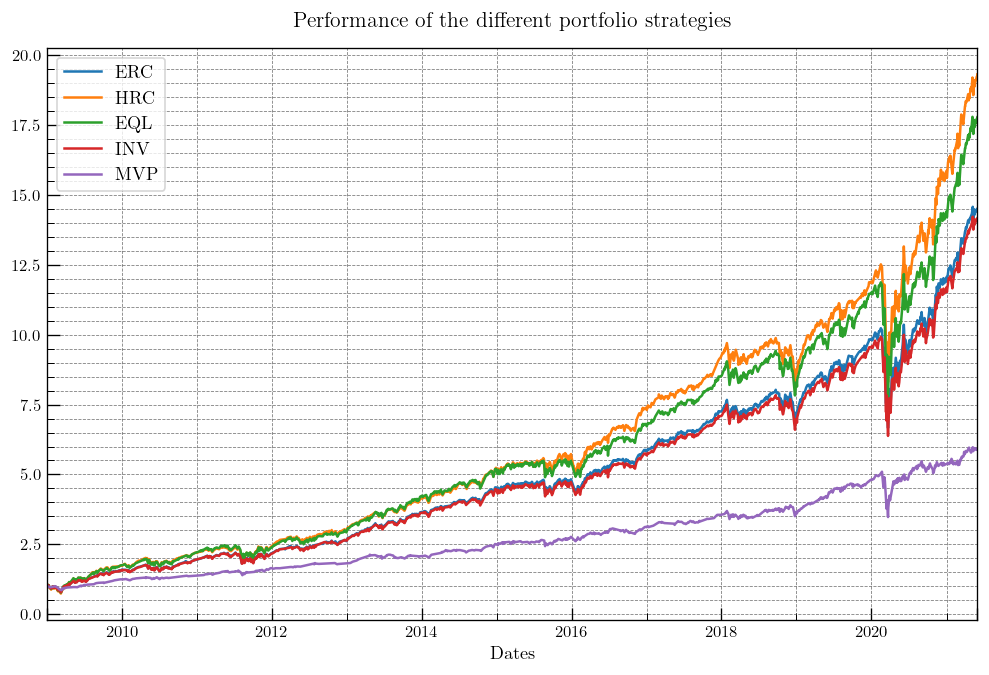

In [20]:
erc_ptf.plot(label='ERC')
hrc_ptf.plot(label='HRC')
eql_ptf.plot(label='EQL')
inv_ptf.plot(label='INV')
mvp_ptf.plot(label='MVP')
plt.legend();
plt.title('Performance of the different portfolio strategies')

In [21]:
# Compute the compound annual returns
n = erc_ret.shape[0] - 1
erc_annual_ret = np.power(erc_ptf[-1], 252/n) - 1
hrc_annual_ret = np.power(hrc_ptf[-1], 252/n) - 1
eql_annual_ret = np.power(eql_ptf[-1], 252/n) - 1
inv_annual_ret = np.power(inv_ptf[-1], 252/n) - 1
mvp_annual_ret = np.power(mvp_ptf[-1], 252/n) - 1

In [22]:
rf = pd.read_csv('pickles/DGS1MO.csv', index_col=0, parse_dates=True)

rf = rf.replace('.', np.nan).astype(float) / 100

rf = rf.reindex(returns.index).ffill().bfill()

In [23]:
rf_annual_ret = (np.power(rf.add(1).prod(), 252/n) - 1).values

In [24]:
# Compute the annual volatility

erc_annual_vol = np.log(erc_ret.add(1)).std() * np.sqrt(252)
hrc_annual_vol = np.log(hrc_ret.add(1)).std() * np.sqrt(252)
eql_annual_vol = np.log(eql_ret.add(1)).std() * np.sqrt(252)
inv_annual_vol = np.log(inv_ret.add(1)).std() * np.sqrt(252)
mvp_annual_vol = np.log(mvp_ret.add(1)).std() * np.sqrt(252)

In [38]:
estimates = ['Return', 'Volatility', 'Sharpe', 'Turnover(Avg)',
            'Mod. Herfindahl', 'VaR 1D 1%', 'VaR 1W 1%', 'VaR 1M 1%', 
             'Drawdown 1D', 'Drawdown 1W', 'Drawdown 1M', 'Max Drawdown']

strategies = ['ERC', 'HRC', 'EQL', 'INV', 'MVP']

summary_statistics = pd.DataFrame(index=estimates, columns=strategies, dtype=float)

In [39]:
summary_statistics.loc['Return', 'ERC'] = erc_annual_ret * 100
summary_statistics.loc['Return', 'HRC'] = hrc_annual_ret * 100
summary_statistics.loc['Return', 'EQL'] = eql_annual_ret * 100
summary_statistics.loc['Return', 'INV'] = inv_annual_ret * 100
summary_statistics.loc['Return', 'MVP'] = mvp_annual_ret * 100

summary_statistics.loc['Volatility', 'ERC'] = erc_annual_vol * 100
summary_statistics.loc['Volatility', 'HRC'] = hrc_annual_vol * 100
summary_statistics.loc['Volatility', 'EQL'] = eql_annual_vol * 100
summary_statistics.loc['Volatility', 'INV'] = inv_annual_vol * 100
summary_statistics.loc['Volatility', 'MVP'] = mvp_annual_vol * 100

In [40]:
# Drawdown
summary_statistics.loc['Drawdown 1D', 'ERC'] = erc_ret.mul(100).min()
summary_statistics.loc['Drawdown 1D', 'HRC'] = hrc_ret.mul(100).min()
summary_statistics.loc['Drawdown 1D', 'EQL'] = eql_ret.mul(100).min()
summary_statistics.loc['Drawdown 1D', 'INV'] = inv_ret.mul(100).min()
summary_statistics.loc['Drawdown 1D', 'MVP'] = mvp_ret.mul(100).min()

summary_statistics.loc['Drawdown 1W', 'ERC'] = erc_ptf.resample('W').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1W', 'HRC'] = hrc_ptf.resample('W').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1W', 'EQL'] = eql_ptf.resample('W').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1W', 'INV'] = inv_ptf.resample('W').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1W', 'MVP'] = mvp_ptf.resample('W').apply(max_drawdown).min()

summary_statistics.loc['Drawdown 1M', 'ERC'] = erc_ptf.resample('BM').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1M', 'HRC'] = hrc_ptf.resample('BM').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1M', 'EQL'] = eql_ptf.resample('BM').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1M', 'INV'] = inv_ptf.resample('BM').apply(max_drawdown).min()
summary_statistics.loc['Drawdown 1M', 'MVP'] = mvp_ptf.resample('BM').apply(max_drawdown).min()

In [41]:
summary_statistics.loc['Max Drawdown', 'ERC'] = max_drawdown(erc_ptf)
summary_statistics.loc['Max Drawdown', 'HRC'] = max_drawdown(hrc_ptf)
summary_statistics.loc['Max Drawdown', 'EQL'] = max_drawdown(eql_ptf)
summary_statistics.loc['Max Drawdown', 'INV'] = max_drawdown(inv_ptf)
summary_statistics.loc['Max Drawdown', 'MVP'] = max_drawdown(mvp_ptf)

In [42]:
summary_statistics.loc['VaR 1D 1%', 'ERC'] = erc_ret.quantile(.01) * 100
summary_statistics.loc['VaR 1D 1%', 'HRC'] = hrc_ret.quantile(.01) * 100
summary_statistics.loc['VaR 1D 1%', 'EQL'] = eql_ret.quantile(.01) * 100
summary_statistics.loc['VaR 1D 1%', 'INV'] = inv_ret.quantile(.01) * 100
summary_statistics.loc['VaR 1D 1%', 'MVP'] = mvp_ret.quantile(.01) * 100

summary_statistics.loc['VaR 1W 1%', 'ERC'] = erc_ptf.resample('W').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1W 1%', 'HRC'] = hrc_ptf.resample('W').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1W 1%', 'EQL'] = eql_ptf.resample('W').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1W 1%', 'INV'] = inv_ptf.resample('W').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1W 1%', 'MVP'] = mvp_ptf.resample('W').first().pct_change().dropna().quantile(.01) * 100

summary_statistics.loc['VaR 1M 1%', 'ERC'] = erc_ptf.resample('BM').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1M 1%', 'HRC'] = hrc_ptf.resample('BM').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1M 1%', 'EQL'] = eql_ptf.resample('BM').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1M 1%', 'INV'] = inv_ptf.resample('BM').first().pct_change().dropna().quantile(.01) * 100
summary_statistics.loc['VaR 1M 1%', 'MVP'] = mvp_ptf.resample('BM').first().pct_change().dropna().quantile(.01) * 100

In [43]:
summary_statistics.loc['Sharpe', 'ERC'] = (summary_statistics.loc['Return', 'ERC'] - rf_annual_ret) / summary_statistics.loc['Volatility', 'ERC']
summary_statistics.loc['Sharpe', 'HRC'] = (summary_statistics.loc['Return', 'HRC'] - rf_annual_ret) / summary_statistics.loc['Volatility', 'HRC']
summary_statistics.loc['Sharpe', 'EQL'] = (summary_statistics.loc['Return', 'EQL'] - rf_annual_ret) / summary_statistics.loc['Volatility', 'EQL']
summary_statistics.loc['Sharpe', 'INV'] = (summary_statistics.loc['Return', 'INV'] - rf_annual_ret) / summary_statistics.loc['Volatility', 'INV']
summary_statistics.loc['Sharpe', 'MVP'] = (summary_statistics.loc['Return', 'MVP'] - rf_annual_ret) / summary_statistics.loc['Volatility', 'MVP']

In [44]:
summary_statistics.loc['Turnover(Avg)', 'ERC'] = turnover(erc_wt, erc_wt.shift()).mul(100).mean()
summary_statistics.loc['Turnover(Avg)', 'HRC'] = turnover(hrc_wt, hrc_wt.shift()).mul(100).mean()
summary_statistics.loc['Turnover(Avg)', 'EQL'] = turnover(eql_wt, eql_wt.shift()).mul(100).mean()
summary_statistics.loc['Turnover(Avg)', 'INV'] = turnover(inv_wt, inv_wt.shift()).mul(100).mean()
summary_statistics.loc['Turnover(Avg)', 'MVP'] = turnover(mvp_wt, mvp_wt.shift()).mul(100).mean()

We use here a modified Herfindahl instead of the Herfindahl to get 0 value for an equal weight portfolio and 1 for a perfectly concentrated portfolio:

$$ \tilde{H} = \frac{H-\frac{1}{n}}{1 - \frac{1}{n}} $$

Where $H$ denotes the Herfindahl index

In [45]:
summary_statistics.loc['Mod. Herfindahl', 'ERC'] = erc_wt.apply(herfindahl, axis=1).mul(100).mean()
summary_statistics.loc['Mod. Herfindahl', 'HRC'] = hrc_wt.apply(herfindahl, axis=1).mul(100).mean()
summary_statistics.loc['Mod. Herfindahl', 'EQL'] = eql_wt.apply(herfindahl, axis=1).mul(100).mean()
summary_statistics.loc['Mod. Herfindahl', 'INV'] = inv_wt.apply(herfindahl, axis=1).mul(100).mean()
summary_statistics.loc['Mod. Herfindahl', 'MVP'] = mvp_wt.apply(herfindahl, axis=1).mul(100).mean()

In [46]:
def df_style(styler):
    styler.format('{:,.2f}%')
    styler.format(formatter="{:.2f}", subset=pd.IndexSlice[['Sharpe', 'Turnover(Avg)', 'Mod. Herfindahl'], :])
    styler.background_gradient(cmap="Blues_r")
    return styler

summary_statistics.style.pipe(df_style)

,ERC,HRC,EQL,INV,MVP
Return,23.14%,25.91%,25.10%,22.91%,14.83%
Volatility,17.55%,19.36%,19.44%,17.94%,13.16%
Sharpe,1.19,1.22,1.17,1.15,0.95
Turnover(Avg),0.71,14.69,0.00,0.46,8.72
Mod. Herfindahl,0.04,0.26,-0.00,0.03,8.05
VaR 1D 1%,-3.01%,-3.40%,-3.40%,-3.16%,-2.06%
VaR 1W 1%,-6.94%,-6.87%,-7.22%,-7.16%,-5.30%
VaR 1M 1%,-10.88%,-12.38%,-11.66%,-11.16%,-8.32%
Drawdown 1D,-11.40%,-11.48%,-11.73%,-11.68%,-9.93%
Drawdown 1W,-14.32%,-14.38%,-14.61%,-14.41%,-14.32%
